In [1]:
import numpy as np
import os
import pandas as pd
import sys
import torch

import matplotlib.pyplot as plt

In [2]:
sys.path.append(os.path.join(sys.path[0], '../..'))

import endure.lsm.cost_model as Cost
from endure.lsm.solver import EndureLevelSolver
from endure.data.io import Reader
from endure.ltune.data.generator import LTuneGenerator
from endure.ltune.model.builder import LTuneModelBuilder

In [3]:
config = Reader.read_config('../../endure.toml')
data_generator = LTuneGenerator(config)
cf = Cost.EndureLevelCost(config)
solver = EndureLevelSolver(config)

In [28]:
model_path = '/data/models/level-tuner-02-27'
model_config = Reader.read_config(os.path.join(model_path, 'endure.toml'))
model = LTuneModelBuilder(model_config).build_model()
model_data = torch.load(os.path.join(model_path, 'best.model'))
status = model.load_state_dict(model_data)
status

<All keys matched successfully>

In [29]:
def model_out_to_design(output):
    h = output[:, 0].item()
    size_ratio = torch.argmax(output[:, 1:]).item()
    return np.array([h, size_ratio + config['lsm']['size_ratio']['min']])

In [30]:
def eval_rand_workloads():
    WORKLOADS = 100
    df = []
    for _ in range(WORKLOADS):
        z0, z1, q, w = data_generator._sample_workload(4)
        # eval normal
        stune_h, stune_T = solver.find_nominal_design(z0, z1, q, w).x
        stune_T = np.ceil(stune_T)
        stune_h = np.around(stune_h, 3)
        stune_cost = cf(stune_h, stune_T, z0, z1, q, w)
        # eval learned
        x = torch.Tensor((z0, z1, q, w)).view(1, -1)
        ltune_h, ltune_T = model_out_to_design(model(x, hard=True))
        ltune_cost = cf(ltune_h, ltune_T, z0, z1, q, w)
        
        row = {
            'z0': z0,
            'z1': z1,
            'q': q,
            'w': w,
            'stune_h': stune_h,
            'stune_T': stune_T,
            'stune_cost': stune_cost,
            'ltune_h': ltune_h,
            'ltune_T': ltune_T,
            'ltune_cost': ltune_cost,
        }
        df.append(row)
    
    return pd.DataFrame(df)

In [31]:
df = eval_rand_workloads()
df['delta'] = (df['stune_cost'] - df['ltune_cost']) / df['stune_cost']

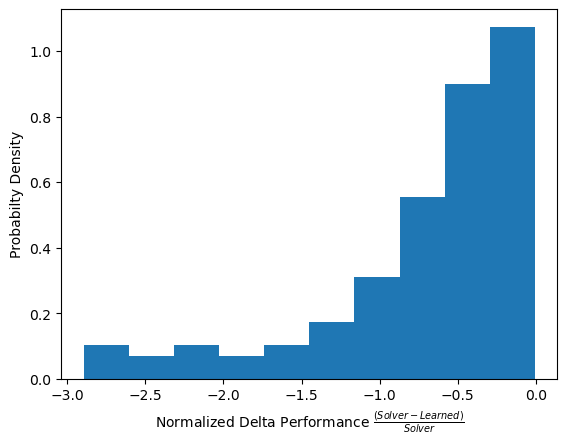

In [32]:
fig, ax = plt.subplots()
ax.hist(df['delta'], bins=10, density=True)
ax.set_ylabel('Probabilty Density')
ax.set_xlabel('Normalized Delta Performance $\\frac{(Solver - Learned)}{Solver}$')
plt.show()

In [33]:
df

,z0,z1,q,w,stune_h,stune_T,stune_cost,ltune_h,ltune_T,ltune_cost,delta
0,0.454,0.076,0.097,0.373,4.383,4.0,2.691249,0.0,3.0,3.629456,-0.348614
1,0.154,0.024,0.211,0.611,1.696,5.0,4.383494,0.0,19.0,7.363876,-0.679910
2,0.373,0.047,0.400,0.180,3.352,9.0,2.866322,0.0,14.0,3.261713,-0.137944
3,0.012,0.312,0.252,0.424,0.352,5.0,3.753329,0.0,8.0,3.995944,-0.064640
4,0.421,0.073,0.361,0.145,3.763,9.0,2.513359,0.0,6.0,3.069734,-0.221367
...,...,...,...,...,...,...,...,...,...,...,...
95,0.474,0.336,0.114,0.076,5.510,8.0,1.380820,0.0,22.0,2.112239,-0.529699
96,0.582,0.135,0.003,0.280,5.863,3.0,1.703190,0.0,45.0,6.345062,-2.725398
97,0.311,0.016,0.308,0.365,2.915,6.0,3.593417,0.0,33.0,6.820349,-0.898012
98,0.424,0.094,0.374,0.108,3.869,11.0,2.295876,0.0,4.0,3.456509,-0.505530


In [22]:
check = df[['z0', 'z1', 'q', 'w']].sum(axis=1)
check[check < 1]

Series([], dtype: float64)